In [1]:
import os
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import data
import models
import pvnet_utils
reload(pvnet_utils)

ROOT_DIR = "dataset/LINEMOD"
FOLDERNAME = 'cs231a/pvnet/'

%matplotlib inline

### Split files into test and train split

In [2]:
reload(data)
X_train, X_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR,['duck', 'cat', 'lamp'], 
                                                                    test_size=0.33, 
                                                                    random_state=2, 
                                                                    shuffle=True)

X = X_train[:1, :]
y = y_train[:1]

print(X)
print(y)

[['dataset/LINEMOD/cat/JPEGImages/001006.jpg'
  'dataset/LINEMOD/cat/mask/1006.png'
  'dataset/LINEMOD/cat/labels/001006.txt']]
['cat']


### Create Dataset and Dataloader and visualize some batches

### Visualize a batch

tensor(4)
tensor(1)


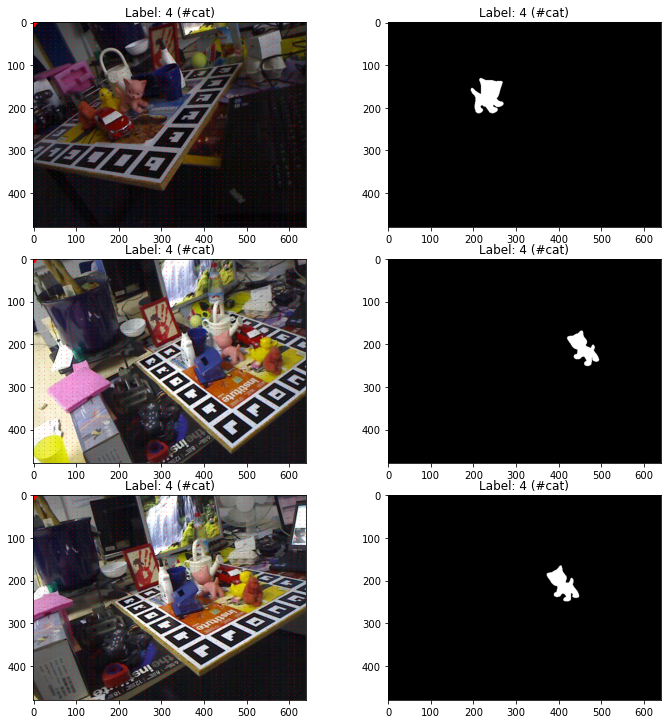

In [3]:
reload(data)
reload(pvnet_utils)
dataset = data.LineModReader((X_train, y_train))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
dataset.show_batch(3)

print(dataset[0]['class_label'])
print(dataset[0]['class_mask'].max())

torch.Size([1, 3, 480, 640])


C:\Users\chasi\ana\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


torch.Size([13, 480, 640])
torch.Size([1, 480, 640])


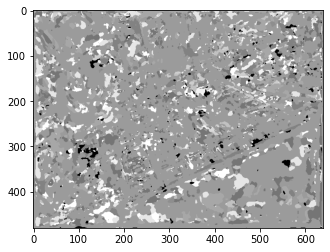

In [4]:
from torchsummary import summary
reload(models)


# Test model
newmodel = models.PvNet(
    num_classes = 12,
    num_keypoints = 9,
    norm_layer = None,
    output_class = True,
    output_vector = False,
    pretrained = True
)
# summary(newmodel,(3,640,480))

# Outputs
print(torch.unsqueeze(dataset[0]['img'],0).size())

class_out = (newmodel(torch.unsqueeze(dataset[0]['img'],0)))['class'][0]
print(class_out.size())

# Get top class, scale by 12 for vis diff
classviz = torch.topk(class_out, 1, dim=0)[1] * 12
print(classviz.size())

plt.imshow(dataset.tensorToImage(classviz.type(torch.FloatTensor)),cmap='gray')
plt.show()


del newmodel
del dataset

# newmodel(dataset)

### Starting Tensorboard

In [5]:
!pip install tensorboard
%reload_ext tensorboard

#%tensorboard --logdir "/content/drive/MyDrive/$FOLDERNAME/runs" --port 6009
%tensorboard --logdir "./runs" --port 6010

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Reusing TensorBoard on port 6010 (pid 12116), started 10:10:25 ago. (Use '!kill 12116' to kill it.)

## Model Training

In [6]:
reload(data)
reload(models)

x_train, x_test, y_train, y_test = pvnet_utils.get_test_train_split(ROOT_DIR, ['duck', 'cat', 'lamp'], test_size=0.2, shuffle=False)

train_dataset = data.LineModReader((x_train, y_train))
test_dataset = data.LineModReader((x_test, y_test))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

class_model = models.PvNet(
    num_classes = 13,
    num_keypoints = 9,
    norm_layer = None,
    output_class = True,
    output_vector = True,
    pretrained = True
)

In [ ]:
import training
reload(training)
reload(pvnet_utils)

training.train(epochs= 1,
    train_data_loader = train_dataloader,
    test_data_loader = train_dataloader,
    device = 'cpu',
    model = class_model)

Epoch 1/1:   0%|▏                                                               | 1/366 [01:50<11:12:17, 110.51s/batch]

epoch:1/1, batch:1/366, accuracy: 18.16%, total_loss:2.5267, class_loss:2.4502, vector_loss:0.0766


Epoch 1/1:   1%|▎                                                               | 2/366 [03:44<11:17:08, 111.62s/batch]

epoch:1/1, batch:2/366, accuracy: 18.25%, total_loss:2.5051, class_loss:2.4289, vector_loss:0.0762


Epoch 1/1:   1%|▌                                                               | 3/366 [05:44<11:29:48, 114.02s/batch]

epoch:1/1, batch:3/366, accuracy: 24.00%, total_loss:2.4788, class_loss:2.4040, vector_loss:0.0747


Epoch 1/1:   1%|▌                                                               | 3/366 [05:48<11:29:48, 114.02s/batch]

In [ ]:

plt.imshow(train_dataset.tensorToImage(train_dataset[0]['img']].type(torch.FloatTensor)))
plt.show()


class_out = (class_model(torch.unsqueeze(train_dataset[0]['img'],0)))['class'][0]
print(class_out.size())

# Get top class, scale by 12 for vis diff
classviz = torch.topk(class_out, 1, dim=0)[1] * 13
print(classviz.size())

plt.imshow(train_dataset.tensorToImage(classviz.type(torch.FloatTensor)),cmap='gray')
plt.show()

# Test model
newmodel = models.PvNet(
    num_classes = 12,
    num_keypoints = 9,
    norm_layer = None,
    output_class = True,
    output_vector = False,
    pretrained = True
)

new_class_out = (newmodel(torch.unsqueeze(train_dataset[0]['img'],0)))['class'][0]

# Get top class, scale by 12 for vis diff
new_classviz = torch.topk(new_class_out, 1, dim=0)[1] * 13

plt.imshow(train_dataset.tensorToImage(new_classviz.type(torch.FloatTensor)),cmap='gray')
plt.show()